In [27]:
import pandas as pd
from utils import *
import time
import numpy as np
import math
import matplotlib.pyplot as plt
# Torch package
import torch
from torch.utils.data import DataLoader
from torch import nn
import torch
from torch import nn
from torch.utils.data import Dataset
import torch.optim as optim
import torch.utils.data as data
import random
import tensorflow as tf

In [28]:
tf.random.set_seed(15)
torch.manual_seed(42)
random.seed(42)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({'font.size':20})
legend_prop = {'weight':'bold'}
from pylab import rcParams
rcParams['axes.linewidth'] = 2

## Read Data

In [29]:
df = pd.read_csv('Processed_data.csv')
df = df.drop([ 'Unnamed: 0'], axis=1)
# Used data from Aug 2013 till 1st March 2024 
df=df[500:]
# Remove few redundant data
df=df.drop(columns=['Date'])
df=df.drop(columns=['CUMLOGRET_1'])
df=df.drop(columns=['Gold in USD volume'])
df=df.drop(columns=['Open'])
df=df.drop(columns=['High'])
df=df.drop(columns=['Low'])

In [30]:
# Set target and features
target = "Close"
features = list(df.columns.difference(["Close"]))
print(features)
print(len(features))

['3M', 'BBB_20_2.0', 'BBL_20_2.0', 'BBM_20_2.0', 'BBP_20_2.0', 'BBU_20_2.0', 'Close_copy', 'Crude Futures_close', 'Crude Futures_volume', 'Crude_H-L', 'Crude_O-C', 'EMA_14', 'EMA_21', 'EMA_7', 'FTSE_H-L', 'FTSE_O-C', 'GBP USD ', 'GBP_USD_H-L', 'GBP_USD_O-C', 'Gold in USD close', 'Gold_H-L', 'Gold_O-C', 'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'SMA_14', 'SMA_21', 'SMA_7', 'Volume']
29


## Normalize data

In [31]:
target_mean = df[target].mean()
target_stdev = df[target].std()

for c in df.columns:
    mean = df[c].mean()
    stdev = df[c].std()

    df[c] = (df[c] - mean) / stdev

In [32]:
df.head()

,Close,Volume,EMA_7,EMA_14,EMA_21,SMA_7,SMA_14,SMA_21,MACD_12_26_9,MACDh_12_26_9,...,3M,FTSE_H-L,FTSE_O-C,GBP_USD_H-L,GBP_USD_O-C,Gold_H-L,Gold_O-C,Crude_H-L,Crude_O-C,Close_copy
500,-0.586759,0.718521,-0.725941,-0.794212,-0.861787,-0.745251,-0.748905,-0.830099,0.857920,0.142893,...,-0.414669,-0.110213,-0.940828,0.159355,0.441655,1.705116,-0.309942,-0.730894,0.295629,-0.586759
501,-0.650690,-0.444215,-0.708600,-0.776571,-0.844034,-0.737822,-0.740482,-0.809370,0.863578,0.128215,...,-0.412881,-0.151148,0.541553,1.923313,-0.106166,1.385769,0.666877,-0.518520,0.365571,-0.650690
502,-0.703747,-0.650799,-0.709025,-0.768534,-0.832895,-0.729285,-0.731869,-0.787001,0.822823,0.005250,...,-0.412881,0.303229,0.451050,0.252315,1.465842,1.066422,1.643696,-0.306146,0.435514,-0.703747
503,-0.732619,-0.304666,-0.716653,-0.765515,-0.825489,-0.715939,-0.727467,-0.772880,0.762045,-0.141106,...,-0.412881,-0.251439,0.249758,-0.777813,-0.205409,0.013439,-0.285212,-0.817284,0.192556,-0.732619
504,-0.906976,-0.513727,-0.766512,-0.786729,-0.835188,-0.729204,-0.744258,-0.773054,0.590776,-0.522973,...,-0.412881,0.690063,1.460629,3.787425,0.076441,1.282197,-2.197634,-0.586912,0.207281,-0.906976


## Data processing for time series model

The data processing is to prepare the data in a sequence of past observations. Preparation of the time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance and window decides how many days we want to predict for. If the sequence length is $n$ and window is $w$, then the LSTM considers the last $n$ observations to predict the next $w$ day price.

In [33]:
sequence_length = 30
window =6

def create_dataset(dataset,target,features, lookback, window):
    X_store, y_store = [], []
    for i in range(0,len(dataset)-lookback-window,2):
        X = (dataset[features].values)[i:i+lookback]
        y = (dataset[target].values)[i+lookback:i+lookback+window]
        X_store.append(X)
        y_store.append(y)
    return torch.FloatTensor(np.array(X_store)), torch.FloatTensor(np.array(y_store))

In [34]:
# Split train test data
from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.05)
size=int(len(df)*0.96)
df_train=df[:size]
df_test=df[size:]
print('Total sample', len(df))
print('Train sample', len(df_train))
print('Test sample', len(df_test))

Total sample 2758
Train sample 2647
Test sample 111


In [35]:
# Train data
X_train, y_train = create_dataset(
    df_train,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

indices = tf.range(start=0, limit=tf.shape(X_train)[0])
shuffled_indices = tf.random.shuffle(indices)
X_train = tf.gather(X_train, shuffled_indices)
y_train = tf.gather(y_train, shuffled_indices)

X_train=torch.FloatTensor(np.array(X_train))
y_train=torch.FloatTensor(np.array(y_train))

print(X_train.shape, y_train.shape)

torch.Size([1306, 30, 29]) torch.Size([1306, 6])


In [36]:
# Test data
X_test, y_test = create_dataset(
    df_test,
    target=target,
    features=features,
    lookback=sequence_length, window=window)

X_test=torch.FloatTensor(np.array(X_test))
y_test=torch.FloatTensor(np.array(y_test))

print(X_test.shape, y_test.shape)

torch.Size([38, 30, 29]) torch.Size([38, 6])


In [37]:
batch_size=10
train_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=batch_size)
test_loader= DataLoader(data.TensorDataset(X_test, y_test), shuffle=True, batch_size=batch_size)

In [38]:
# The unknown data
X_check=(df_train[features].values)[len(df_train)-sequence_length:len(df_train)]
y_check=(df_test[target].values)[:window]
torch.FloatTensor([X_check]).shape

torch.Size([1, 30, 29])

## Classical LSTM

We first define train_model: function to train the model based on the batches of data
We print the loss at the end to understand how the model is performing with regards to the data.

In [39]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Classical LSTM

In [40]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1) # The output dimesion is set as window
        self.linear_2 = nn.Linear(in_features=30, out_features=6)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        
        out_l1, (hn, _) = self.lstm(x, (h0, c0))
        out_l2 = self.linear(out_l1)
        out = self.linear_2(torch.squeeze(out_l2))
        return torch.squeeze(out)

In [41]:
learning_rate = 0.001
num_hidden_units = 16

model_lstm = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [42]:
lstm_loss_train = []
lstm_loss_test=[]
num_epoch=10
for ix_epoch in range(num_epoch):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model_lstm, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model_lstm, loss_function)
    lstm_loss_train.append(train_loss)
    lstm_loss_test.append(test_loss)

Epoch 0
---------
Train loss: 0.45355936250727596
Test loss: 0.03372592618688941
Epoch 1
---------
Train loss: 0.11527287226369362
Test loss: 0.03008799348026514
Epoch 2
---------
Train loss: 0.08185798755868245
Test loss: 0.045939779840409756
Epoch 3
---------
Train loss: 0.06374522935570652
Test loss: 0.06955239363014698
Epoch 4
---------
Train loss: 0.0556238949412608
Test loss: 0.034197764936834574
Epoch 5
---------
Train loss: 0.050382812841589214
Test loss: 0.05283508263528347
Epoch 6
---------
Train loss: 0.04542949608747513
Test loss: 0.03963572718203068
Epoch 7
---------
Train loss: 0.04194873298397501
Test loss: 0.03592234058305621
Epoch 8
---------
Train loss: 0.03962179030227752
Test loss: 0.03374815289862454
Epoch 9
---------
Train loss: 0.03639845809550913
Test loss: 0.06457534618675709


In [43]:
lstm_loss_train

[0.45355936250727596,
 0.11527287226369362,
 0.08185798755868245,
 0.06374522935570652,
 0.0556238949412608,
 0.050382812841589214,
 0.04542949608747513,
 0.04194873298397501,
 0.03962179030227752,
 0.03639845809550913]

In [44]:
lstm_loss_test

[0.03372592618688941,
 0.03008799348026514,
 0.045939779840409756,
 0.06955239363014698,
 0.034197764936834574,
 0.05283508263528347,
 0.03963572718203068,
 0.03592234058305621,
 0.03374815289862454,
 0.06457534618675709]

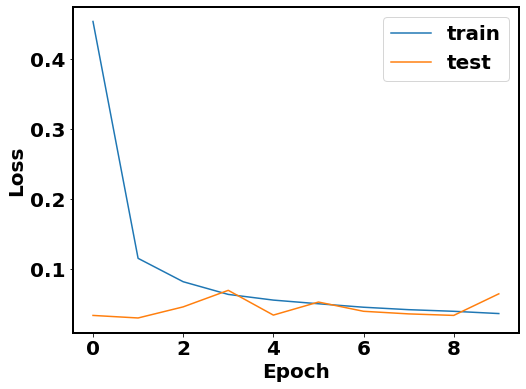

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(range(num_epoch), lstm_loss_train, label='train')
plt.plot(range(num_epoch), lstm_loss_test, label='test')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [46]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output.append(y_star.numpy())  
    return output

In [47]:
# Prepare data to evaluate training accuracy of lstm
train_eval_loader = DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=batch_size)
y_train_pred_lstm=predict(train_eval_loader, model_lstm)
y_train_lstm=[]
for X, y in train_eval_loader:
    y_train_lstm.append(y)
    
# Prepare data to evaluate test accuracy of lstm
test_eval_loader = DataLoader(data.TensorDataset(X_test, y_test), shuffle=False, batch_size=batch_size)
y_test_pred_lstm=predict(test_eval_loader, model_lstm)
y_test_lstm=[]
for X, y in test_eval_loader:
    y_test_lstm.append(y)

In [48]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
def cal_metrics(y_true,y_pred):
    mae=0
    rmse=0
    for i in range(len(y_true)):
        y1=y_true[i].flatten().numpy()* target_stdev + target_mean
        y2=y_pred[i].flatten()* target_stdev + target_mean
        mae=mean_absolute_error(y1, y2)+mae
        rmse=mean_squared_error(y1, y2, squared=False)+rmse  
    return mae/len(y_true) , rmse/len(y_true)

In [49]:
mae_train_lstm, rmse_train_lstm= cal_metrics(y_train_lstm,y_train_pred_lstm)
print('MAE train error is',mae_train_lstm)
print('RMSE train error is',rmse_train_lstm)

mae_test_lstm, rmse_test_lstm= cal_metrics(y_test_lstm,y_test_pred_lstm)
print('MAE test error is',mae_test_lstm)
print('RMSE test error is',rmse_test_lstm)

MAE train error is 74.93221871179479
RMSE train error is 97.74934436710737
MAE test error is 109.78248977661133
RMSE test error is 130.50122451782227


In [52]:
total_params_Q = sum(p.numel() for p in model_lstm.parameters() if p.requires_grad)

print("No. of parameters for QLSTM: ", total_params_Q)

No. of parameters for QLSTM:  5387
